Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import gzip
import pandas as pd
import re
import unicodedata
import string
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud



---



Load the Data

In [ ]:
product_df = pd.read_csv('/content/drive/MyDrive/final_product_data.csv')

<ipython-input-3-ebb289327c50>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  product_df = pd.read_csv('/content/drive/MyDrive/final_product_data.csv')


In [ ]:
product_df.head()

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,sentiment_polarity,review_class,ratingClass
0,0,5,2.0,True,2013-02-28,A15U5NUS1EY7IQ,B000001OMI,{'Format:': ' Personal Computers'},S. Bommarito,im getting listening station going several ele...,Works well,1362009600,0,0.166667,Good,Good
1,1,5,5.0,True,2012-10-17,AHGGNAIT6BH5X,B000001OMI,0,Edward H,needed headset watching editing video late nig...,HP 200 Stereo Headset,1350432000,0,0.270833,Good,Good
2,2,4,0,False,2012-09-27,A33HUURDJ4DVG3,B000001OMI,{'Format:': ' Personal Computers'},HB,wa town month needed pair headphone walking wa...,"For the price, you cannot beat them",1348704000,0,0.069907,Good,Good
3,3,5,4.0,True,2008-11-27,A680RUE1FDO8B,B000001OMI,{'Format:': ' Personal Computers'},Jerry Saperstein,obviously headphone audiophile person expects ...,Excellent day-to-day headphones,1227744000,0,0.106364,Good,Good
4,4,3,2.0,False,2007-12-24,A3OLAZKM77XR6P,B000001OMI,{'Format:': ' Personal Computers'},Tennis Ace,bought headphone tower records year ago nice f...,Foldable but didn't last long,1198454400,0,0.047959,Good,Average




---



Drop the First Column

In [ ]:
product_df.drop(columns='Unnamed: 0', inplace=True)



---



Replace the acronyms in the Review Text column

In [ ]:
acronym_expansions = {
    'CPU': 'Central Processing Unit',
    'GPU': 'Graphics Processing Unit',
    'RAM': 'Random Access Memory',
    'SSD': 'Solid State Drive',
    'HDD': 'Hard Disk Drive',
    'USB': 'Universal Serial Bus',
    'HDR': 'High Dynamic Range',
    '4K': 'Ultra High Definition (UHD)',
    'HDR10': 'High Dynamic Range 10',
    'OLED': 'Organic Light Emitting Diode',
    'LED': 'Light Emitting Diode',
    'LCD': 'Liquid Crystal Display',
    'IPS': 'In-Plane Switching',
    'Hz': 'Hertz',
    'GHz': 'Gigahertz',
    'Mbps': 'Megabits Per Second',
    'MP': 'Megapixels',
    'mAh': 'Milliampere-hour',
    'OS': 'Operating System',
    'IoT': 'Internet of Things',
    'NFC': 'Near Field Communication',
    'GPS': 'Global Positioning System',
    'Bluetooth': 'Short-Range Wireless Technology',
    'Wi-Fi': 'Wireless Fidelity',
    'HDMI': 'High-Definition Multimedia Interface',
    'VGA': 'Video Graphics Array',
    'SD': 'Secure Digital',
    'VR': 'Virtual Reality',
    'AR': 'Augmented Reality',
    'AI': 'Artificial Intelligence',
    'UI': 'User Interface',
    'UX': 'User Experience',
    'DLNA': 'Digital Living Network Alliance',
    'ISP': 'Internet Service Provider',
    'FCC': 'Federal Communications Commission',
    'RF': 'Radio Frequency',
    'IR': 'Infrared',
    'LCD': 'Liquid Crystal Display',
    'AC': 'Alternating Current',
    'DC': 'Direct Current',
    'WLAN': 'Wireless Local Area Network',
    'LAN': 'Local Area Network',
    'OTA': 'Over-The-Air',
    'VoIP': 'Voice over Internet Protocol',
    'VPN': 'Virtual Private Network',
    'CPU': 'Central Processing Unit',
    'GPU': 'Graphics Processing Unit',
    'RFID': 'Radio-Frequency Identification',
    'CAD': 'Computer-Aided Design',
    'AI': 'Artificial Intelligence',
    'ML': 'Machine Learning',
    'DL': 'Deep Learning',
    'RFID': 'Radio-Frequency Identification',
    'SIM': 'Subscriber Identity Module',
    'AMOLED': 'Active-Matrix Organic Light-Emitting Diode',
    'QC': 'Quick Charge',
    'EMI': 'Electromagnetic Interference',
    'IC': 'Integrated Circuit',
    'EMF': 'Electromagnetic Field',
    'IPS': 'In-Plane Switching',
    'PPI': 'Pixels Per Inch',
    'AR': 'Augmented Reality',
    'IoT': 'Internet of Things',
    'LED': 'Light-Emitting Diode',
    'LTE': 'Long-Term Evolution',
    'MTBF': 'Mean Time Between Failures',
    'OEM': 'Original Equipment Manufacturer',
    'PDF': 'Portable Document Format',
    'SDK': 'Software Development Kit',
    'ISP': 'Internet Service Provider',
    'RF': 'Radio Frequency',
    'QLED': 'Quantum Dot Light Emitting Diode',
    'VA': 'Vertical Alignment',
    'TFT': 'Thin Film Transistor',
    'PWM': 'Pulse Width Modulation',
    'VRR': 'Variable Refresh Rate',
    'VESA': 'Video Electronics Standards Association',
    'WQHD': 'Wide Quad High Definition',
    'VRAM': 'Video Random Access Memory',
    'WLAN': 'Wireless Local Area Network',
    'WWAN': 'Wireless Wide Area Network',
}

In [ ]:
def replace_acronyms(text):
  if isinstance(text, str):
    #define a regular expression
    acronym_pattern = r'\b(?:' + '|'.join(re.escape(key) for key in acronym_expansions.keys()) + r')\b'

    #replace each acronym with its expanded form
    def replace(match):
      return acronym_expansions.get(match.group(0), match.group(0))

    #replace acronyms using the defined function
    replaced_text = re.sub(acronym_pattern, replace, text)

    return replaced_text
  else:
    return text

In [ ]:
product_df['reviewText'] = product_df['reviewText'].apply(replace_acronyms)

In [ ]:
product_df.drop(columns='sentiment_polarity', inplace=True)

In [ ]:
product_df.drop(columns='review_class', inplace=True)

# Word Cloud

In [ ]:
def classify_review(sentiment_polarity):
    if sentiment_polarity > 0:
        return 'Good'
    elif sentiment_polarity < 0:
        return 'Bad'
    else:
        return 'Neutral'

Calculate Sentiment Polarity

In [ ]:
#calculate sentiment polarity for each reviewText
product_df['sentiment_polarity'] = product_df['reviewText'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

Classify each Sentiment Polarity

In [ ]:
#classify reviews as 'Good' or 'Bad'
product_df['review_class'] = product_df['sentiment_polarity'].apply(classify_review)

Get all the words in Good and Bad reveiws each

In [ ]:
good_reviews = ' '.join(product_df[product_df['review_class'] == 'Good']['reviewText'])
bad_reviews = ' '.join(product_df[product_df['review_class'] == 'Bad']['reviewText'])

Create the word clouds

In [ ]:
#Word Cloud for Good ratings
wordcloud_good = WordCloud(width=800, height=400, background_color='white').generate(good_reviews)

#Word Cloud for Bad ratings
wordcloud_bad = WordCloud(width=800, height=400, background_color='white').generate(bad_reviews)

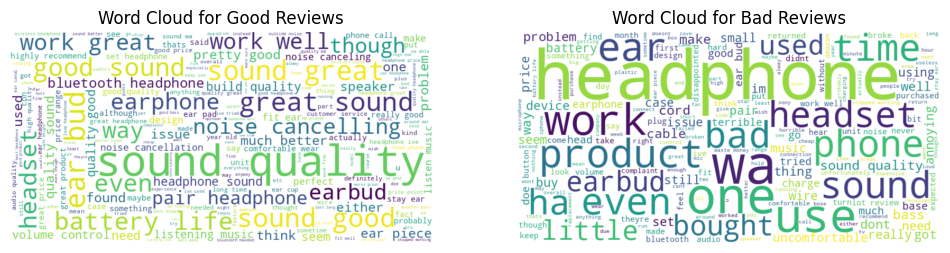

In [ ]:
#plot Word Clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_good, interpolation='bilinear')
plt.title('Word Cloud for Good Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.title('Word Cloud for Bad Reviews')
plt.axis('off')

plt.show()